## Classificação de Risco de Ações Brasileiras - BOVESPA
### Análise Quantitativa e Clustering de Ativos B3
Grupo:  
Eddie Alves Medrado Nascimento  
Gabriel Silva Takarada  
Leonardo Victor Pereira Ferreira    
Marcos Vinicius Hespanholo  


1. Objetivo
Este notebook implementa um sistema robusto de classificação de risco para ações brasileiras negociadas na BOVESPA, 
utilizando técnicas de clustering não supervisionado e análise quantitativa de métricas financeiras.

2. Descrição do Domínio
O sistema analisa ações brasileiras da B3 (Brasil, Bolsa, Balcão), cobrindo diversos setores da economia nacional. A classificação é baseada em métricas quantitativas de risco e fundamentalistas, permitindo:

- Análise de volatilidade e comportamento histórico dos preços    
- Avaliação de risco sistemático (Beta) em relação ao IBOVESPA    
- Medição de perdas máximas (Max Drawdown)    
- Análise de liquidez baseada em volume de negociação 
- Clustering automático em 5 categorias de risco  

3. Características do Dataset   

    3.1 Estrutura dos Dados:   
        Período de Análise: 1 ano (252 dias úteis)      
        Frequência: Dados diários via Yahoo Finance API     
        Benchmark: IBOVESPA (^BVSP)     
        Total de Ações: ~400+ tickers da B3     
        Categorias de Risco: 5 níveis (Muito Baixo, Baixo, Médio, Alto, Muito Alto)   

    3.2 Métricas Calculadas: 
- Volatilidade Anualizada 
- Maximum Drawdown    
- Beta (correlação com IBOVESPA)  
- Liquidez (volume médio) 
- Retorno Médio Anualizado    


## 4. Configurações e Importações

In [1]:

import os
import ssl
import certifi
import numpy as np
import pandas as pd
import yfinance as yf
import logging
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import psycopg2
import warnings
from typing import List, Dict, Tuple, Optional
from IPython.display import display

try:
    from adjustText import adjust_text
    ADJUST_TEXT_INSTALLED = True
except ImportError:
    ADJUST_TEXT_INSTALLED = False

# ================= CONFIGURAÇÕES GERAIS ==================

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
np.random.seed(42)  # Garantir reprodutibilidade

# Certificados SSL
os.environ['SSL_CERT_FILE'] = certifi.where()
ssl._create_default_https_context = ssl._create_unverified_context

# ========= Diretórios base (fallback em notebooks) =========
try:
    # funciona em scripts .py
    BASE_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # fallback para REPL, Jupyter etc.
    BASE_DIR = os.getcwd()

DATA_DIR = os.path.join(BASE_DIR, '..', 'data')
os.makedirs(DATA_DIR, exist_ok=True)

LOG_DIR = os.path.join(BASE_DIR, 'log')
os.makedirs(LOG_DIR, exist_ok=True)
LOG_FILE = os.path.join(
    LOG_DIR,
    f'preprocessing_PIVI{datetime.now().strftime("%Y%m%d_%H%M%S")}.log'
)

# Parâmetros de clusterização e benchmark
N_CLUSTERS = 5
PERIOD = '1y'
BENCHMARK = '^BVSP'

logging.basicConfig(
    filename=LOG_FILE,
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(message)s'
)

print("✅ Configurações inicializadas com sucesso!")
print(f"📊 Período de análise: {PERIOD}")
print(f"📈 Benchmark: {BENCHMARK}")
print(f"🎯 Número de clusters: {N_CLUSTERS}")


✅ Configurações inicializadas com sucesso!
📊 Período de análise: 1y
📈 Benchmark: ^BVSP
🎯 Número de clusters: 5


### 5. Definição dos Tickers B3
Esta função retorna a lista completa de tickers das principais ações brasileiras negociadas na BOVESPA:

In [ ]:
def get_b3_tickers() -> List[str]:  
    tickers = [  
        "JBSS3","BBAS3","COGN3","MGLU3","AZUL4","PETR4","ABEV3","GOLL4","B3SA3","ITSA4","LREN3","VAMO3","BBDC4","ITUB4",  
        "CVCB3","VALE3","RENT3","CSAN3","BHIA3","ASAI3","GGBR4","BEEF3","RADL3","GMAT3","SUZB3","MRVE3","PRIO3","HAPV3",  
        "PETR3","ENEV3"
]
    return tickers  

# Testando a função
tickers = get_b3_tickers()
print(f"📋 Total de tickers B3 carregados: {len(tickers)}")
print(f"🏢 Exemplos: {tickers[:10]}")


📋 Total de tickers B3 carregados: 381
🏢 Exemplos: ['JBSS3', 'BBAS3', 'COGN3', 'MGLU3', 'AZUL4', 'PETR4', 'ABEV3', 'GOLL4', 'B3SA3', 'ITSA4']


### 6. Funções de Extração de Dados
#### 6.1 Download de Dados Históricos

In [3]:
def fetch_stock_data(ticker: str, period: str = PERIOD) -> Optional[pd.DataFrame]:  
    """Baixa histórico de preços de um ticker da B3 via yfinance."""  
    try:  
        data = yf.Ticker(f'{ticker}.SA').history(period=period)  
        if data.empty:  
            logging.warning(f'{ticker}: Histórico vazio.')  
            return None  
        data = data.rename(columns=str.capitalize)  
        required = ['Open', 'High', 'Low', 'Close', 'Volume']  
        for col in required:  
            if col not in data:  
                data[col] = np.nan  
        data = data[required]  
        # Tratamento de valores ausentes e interpolação  
        n_missing = data.isnull().sum().sum()  
        if n_missing > 0:  
            data.interpolate(method='linear', inplace=True)  
            logging.info(f'{ticker}: {n_missing} valores interpolados.')  
        # Remover zero volume (fins de semana/feriados)  
        before = len(data)  
        data = data[data['Volume'] > 0]  
        if before != len(data):  
            logging.info(f'{ticker}: {before-len(data)} registros com volume=0 removidos.')  
        return data  
    except Exception as e:  
        logging.error(f'{ticker}: Falha no download - {str(e)}')  
        return None  

# Testando com uma ação
sample_data = fetch_stock_data('PETR4')
if sample_data is not None:
    print("✅ Download de dados funcionando!")
    print(f"📊 Dados PETR4: {len(sample_data)} registros")
    display(sample_data.head())
else:
    print("❌ Erro no download dos dados")


✅ Download de dados funcionando!
📊 Dados PETR4: 251 registros


,Open,High,Low,Close,Volume
Date,,,,,
2024-06-13 00:00:00-03:00,31.812576,32.069555,30.882122,31.422670,46233500
2024-06-14 00:00:00-03:00,31.449254,31.458114,30.261821,30.731476,53534900
2024-06-17 00:00:00-03:00,30.492219,31.130244,30.368159,30.846678,40941800
2024-06-18 00:00:00-03:00,30.917567,32.025247,30.855537,31.812574,36180700
2024-06-19 00:00:00-03:00,31.812576,32.007525,31.520147,31.839159,20776200


#### 6.2 Coleta de Dados Fundamentalistas

In [4]:
def fetch_fundamental_data(ticker):  
    """Coleta dados fundamentais e cadastrais via yfinance .info"""  
    info = {}  
    try:  
        yf_info = yf.Ticker(f"{ticker}.SA").info  
        info = {  
            'symbol': ticker,  
            'company_name': yf_info.get('longName', ''),  
            'sector': yf_info.get('sector', ''),  
            'industry': yf_info.get('industry', ''),  
            'market_cap': yf_info.get('marketCap', np.nan),  
            'pe_ratio': yf_info.get('trailingPE', np.nan),  
            'price_to_book': yf_info.get('priceToBook', np.nan),  
            'roe': yf_info.get('returnOnEquity', np.nan),  
            'dividend_yield': yf_info.get('dividendYield', np.nan),  
            'profit_margins': yf_info.get('profitMargins', np.nan),  
            'gross_margins': yf_info.get('grossMargins', np.nan),  
            'ebitda_margins': yf_info.get('ebitdaMargins', np.nan),  
            'enterprise_value': yf_info.get('enterpriseValue', np.nan),  
            'revenue': yf_info.get('totalRevenue', np.nan),  
            'website': yf_info.get('website', ''),  
            'description': yf_info.get('longBusinessSummary', '')[:500]  
        }  
    except Exception as e:  
        print(f"[ERRO] Erro ao buscar metadados de {ticker}: {e}")  
    return info  

# Testando dados fundamentalistas
fund_data = fetch_fundamental_data('PETR4')
print("✅ Dados fundamentalistas coletados:")
for key, value in list(fund_data.items())[:8]:
    print(f"{key}: {value}")


✅ Dados fundamentalistas coletados:
symbol: PETR4
company_name: Petróleo Brasileiro S.A. - Petrobras
sector: Energy
industry: Oil & Gas Integrated
market_cap: 437502443520
pe_ratio: 8.768193
price_to_book: 1.059195
roe: 0.12019


#### 6.3 Download do Benchmark (IBOVESPA)

In [5]:
def fetch_benchmark_returns(period: str = PERIOD) -> Optional[pd.Series]:  
    try:  
        hist = yf.Ticker(BENCHMARK).history(period=period)  
        if hist.empty:  
            logging.warning(f'{BENCHMARK}: Histórico vazio.')  
            return None  
        returns = np.log(hist['Close'] / hist['Close'].shift(1)).dropna()  
        return returns  
    except Exception as e:  
        logging.error(f'Benchmark fetch failed: {e}')  
        return None  

# Carregando benchmark
benchmark_returns = fetch_benchmark_returns()
if benchmark_returns is not None:
    print(f"✅ Benchmark IBOVESPA carregado: {len(benchmark_returns)} retornos")
    print(f"📈 Retorno médio diário: {benchmark_returns.mean():.4f}")
    print(f"📊 Volatilidade diária: {benchmark_returns.std():.4f}")
else:
    print("❌ Erro ao carregar benchmark")


✅ Benchmark IBOVESPA carregado: 250 retornos
📈 Retorno médio diário: 0.0006
📊 Volatilidade diária: 0.0094


### 7. Funções de Análise de Risco
#### 7.1 Detecção de Outliers

In [6]:
def detect_outliers(data: pd.Series, threshold: float = 3.5) -> np.ndarray:  
    """Aplica método MAD para detectar outliers."""  
    median = np.median(data)  
    diff = np.abs(data - median)  
    mad = np.median(diff)  
    if mad < 1e-6:  
        return np.zeros_like(data, dtype=bool)  # Nenhum outlier detectável  
    modified_z = 0.6745 * diff / (mad + 1e-9)  
    return modified_z > threshold  

# Testando detecção de outliers
sample_returns = np.random.normal(0.001, 0.02, 250)
sample_returns[100] = 0.15  # Inserindo outlier
sample_returns[200] = -0.12  # Inserindo outlier

outliers = detect_outliers(pd.Series(sample_returns))
print(f"🎯 Outliers detectados: {outliers.sum()}/{len(sample_returns)}")
print(f"📊 Posições dos outliers: {np.where(outliers)[0]}")


🎯 Outliers detectados: 3/250
📊 Posições dos outliers: [100 200 209]


#### 7.2 Cálculo de Métricas de Risco

In [7]:
def calculate_metrics(prices: pd.DataFrame, benchmark_returns: Optional[pd.Series]) -> Optional[Dict]:  
    """  
    Calcula métricas quantitativas de risco: volatilidade, max_drawdown, beta, etc.  
    Além disso, detecta e remove outliers extremos nos retornos.  
    """  
    results = dict()  
    prices = prices.copy()  
    prices['Returns'] = np.log(prices['Close'] / prices['Close'].shift(1))  
    returns = prices['Returns'].dropna()  
    mask_outlier = detect_outliers(returns, threshold=5.0)  
    returns = returns[~mask_outlier]  
    if len(returns) < 21:  
        logging.warning("Menos de 21 retornos válidos após limpezas.")  
        return None  
    results['volatility'] = returns.std() * np.sqrt(252)  
    results['mean_return'] = returns.mean() * 252  
    cumulative = (1 + returns).cumprod()  
    running_max = cumulative.cummax()  
    drawdown = cumulative / running_max - 1  
    results['max_drawdown'] = abs(drawdown.min())  
    results['liquidity'] = prices['Volume'].mean() / 1e6  
    results['beta'] = np.nan  
    if benchmark_returns is not None:  
        idx = returns.index.intersection(benchmark_returns.index)  
        if len(idx) > 30:  
            ret_stock = returns.loc[idx]  
            ret_bench = benchmark_returns.loc[idx]  
            if ret_bench.nunique() > 1 and ret_stock.nunique() > 1:  
                # np.polyfit retorna coef de inclinação (beta), _  
                beta, _ = np.polyfit(ret_bench, ret_stock, 1)  
                results['beta'] = beta  
            else:  
                results['beta'] = np.nan  
        else:  
            results['beta'] = np.nan  
    return results  

# Testando cálculo de métricas
if sample_data is not None:
    metrics = calculate_metrics(sample_data, benchmark_returns)
    if metrics:
        print("✅ Métricas calculadas com sucesso:")
        for key, value in metrics.items():
            if isinstance(value, float):
                print(f"{key}: {value:.4f}")
            else:
                print(f"{key}: {value}")
else:
    print("❌ Dados de amostra não disponíveis")


✅ Métricas calculadas com sucesso:
volatility: 0.2209
mean_return: 0.0291
max_drawdown: 0.1887
liquidity: 35.1867
beta: 0.7495


#### 7.3 Função para Remover Baixa Variância

In [8]:
def remove_low_variance(df: pd.DataFrame, feats: List[str], threshold: float = 1e-8) -> List[str]:  
    """Remove colunas com variância muito baixa."""  
    low_var_cols = [f for f in feats if df[f].var() < threshold]  
    if low_var_cols:  
        logging.warning(f"Colunas removidas por baixa variância: {low_var_cols}")  
    return [f for f in feats if f not in low_var_cols] 

print("✅ Função de remoção de baixa variância definida")


✅ Função de remoção de baixa variância definida


### 8. Classe para Manipulação de Dados do Banco
#### 8.1 Classe StockDataHandler

In [9]:
class StockDataHandler:
    @staticmethod
    def insert_stocks_supabase(df_all: pd.DataFrame) -> None:
        """
        Insere ou atualiza os dados da tabela 'stocks' no Supabase (Postgres).
        """
        # Carrega variáveis de ambiente
        load_dotenv(dotenv_path=BASE_DIR / "../.env")
        DATABASE_URL = os.getenv("DATABASE_URL")
        assert DATABASE_URL, "DATABASE_URL não configurada."

        conn = psycopg2.connect(DATABASE_URL, sslmode="require")
        cur = conn.cursor()

        MAX_BIGINT = 9223372036854775807

        def cap_bigint(val):
            """
            Limita o valor ao máximo de bigint do Postgres ou retorna None em caso de overflow/NaN.
            """
            try:
                if pd.isna(val):
                    return None
                v = float(val)
                if abs(v) > MAX_BIGINT:
                    return None
                return v
            except Exception:
                return None

        for _, row in df_all.iterrows():
            try:
                cur.execute(
                    """
                    INSERT INTO stocks (
                        symbol, company_name, sector, industry,
                        market_cap, pe_ratio, price_to_book, roe, dividend_yield,
                        profit_margins, gross_margins, ebitda_margins,
                        enterprise_value, revenue, website, description,
                        volatility, max_drawdown, beta, mean_return,
                        liquidity, risk_level, risk_category
                    ) VALUES (
                        %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s,
                        %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s
                    )
                    ON CONFLICT (symbol) DO UPDATE SET
                        company_name   = EXCLUDED.company_name,
                        sector         = EXCLUDED.sector,
                        industry       = EXCLUDED.industry,
                        market_cap     = EXCLUDED.market_cap,
                        pe_ratio       = EXCLUDED.pe_ratio,
                        price_to_book  = EXCLUDED.price_to_book,
                        roe            = EXCLUDED.roe,
                        dividend_yield = EXCLUDED.dividend_yield,
                        profit_margins = EXCLUDED.profit_margins,
                        gross_margins  = EXCLUDED.gross_margins,
                        ebitda_margins = EXCLUDED.ebitda_margins,
                        enterprise_value = EXCLUDED.enterprise_value,
                        revenue        = EXCLUDED.revenue,
                        website        = EXCLUDED.website,
                        description    = EXCLUDED.description,
                        volatility     = EXCLUDED.volatility,
                        max_drawdown   = EXCLUDED.max_drawdown,
                        beta           = EXCLUDED.beta,
                        mean_return    = EXCLUDED.mean_return,
                        liquidity      = EXCLUDED.liquidity,
                        risk_level     = EXCLUDED.risk_level,
                        risk_category  = EXCLUDED.risk_category,
                        updated_at     = CURRENT_TIMESTAMP
                    """,
                    (
                        row["ticker"],
                        row.get("company_name"),
                        row.get("sector"),
                        row.get("industry"),
                        cap_bigint(row.get("market_cap")),
                        row.get("pe_ratio"),
                        row.get("price_to_book"),
                        row.get("roe"),
                        row.get("dividend_yield"),
                        row.get("profit_margins"),
                        row.get("gross_margins"),
                        row.get("ebitda_margins"),
                        cap_bigint(row.get("enterprise_value")),
                        cap_bigint(row.get("revenue")),
                        row.get("website"),
                        row.get("description"),
                        row.get("volatility"),
                        row.get("max_drawdown"),
                        row.get("beta"),
                        row.get("mean_return"),
                        row.get("liquidity"),
                        row.get("risk_level"),
                        row.get("risk_category"),
                    ),
                )
            except Exception as err:
                logging.error(f"Erro ao inserir {row['ticker']} no Supabase: {err}")
                conn.rollback()

        conn.commit()
        cur.close()
        conn.close()
        print("Dados salvos no Supabase com sucesso!")

    @staticmethod
    def insert_stock_prices_supabase(historical_data: Dict[str, pd.DataFrame]) -> None:
        """
        Insere ou atualiza os dados da tabela 'stock_prices' no Supabase (Postgres).
        """
        load_dotenv(dotenv_path=BASE_DIR / "../.env")
        DATABASE_URL = os.getenv("DATABASE_URL")
        assert DATABASE_URL, "DATABASE_URL não configurada."

        conn = psycopg2.connect(DATABASE_URL, sslmode="require")
        cur = conn.cursor()

        try:
            for ticker, df in historical_data.items():
                # Busca o ID da ação
                cur.execute("SELECT id FROM stocks WHERE symbol = %s", (ticker,))
                result = cur.fetchone()
                if result is None:
                    logging.warning(
                        f"Stock {ticker} não encontrado na tabela stocks. Pulando."
                    )
                    continue

                stock_id = result[0]
                df_copy = df.copy().reset_index()

                # Determina coluna de data
                if "Date" in df_copy.columns:
                    date_col = "Date"
                else:
                    date_col = df_copy.columns[0]

                for _, row in df_copy.iterrows():
                    try:
                        adj_close = row.get("Close")
                        cur.execute(
                            """
                            INSERT INTO stock_prices (
                                stock_id, date, open, high, low, close, volume, adj_close
                            ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
                            ON CONFLICT (stock_id, date) DO UPDATE SET
                                open      = EXCLUDED.open,
                                high      = EXCLUDED.high,
                                low       = EXCLUDED.low,
                                close     = EXCLUDED.close,
                                volume    = EXCLUDED.volume,
                                adj_close = EXCLUDED.adj_close
                            """,
                            (
                                stock_id,
                                row[date_col].date()
                                if hasattr(row[date_col], "date")
                                else row[date_col],
                                float(row.get("Open", None))
                                if pd.notna(row.get("Open", None))
                                else None,
                                float(row.get("High", None))
                                if pd.notna(row.get("High", None))
                                else None,
                                float(row.get("Low", None))
                                if pd.notna(row.get("Low", None))
                                else None,
                                float(row.get("Close", None))
                                if pd.notna(row.get("Close", None))
                                else None,
                                int(row.get("Volume", None))
                                if pd.notna(row.get("Volume", None))
                                else None,
                                float(adj_close) if pd.notna(adj_close) else None,
                            ),
                        )
                    except Exception as row_err:
                        logging.error(
                            f"Erro ao inserir preço de {ticker} em {row[date_col]}: {row_err}"
                        )

            conn.commit()
            print("Dados históricos salvos no banco com sucesso!")
        except Exception as e:
            logging.error(f"Erro geral ao inserir dados históricos: {e}")
            conn.rollback()
        finally:
            cur.close()
            conn.close()

### 9. Pipeline Principal - Classe RiskClassifier

In [10]:
class RiskClassifier:
    """Pipeline ETL + modelagem + visualização + exportação."""
    
    def __init__(self, tickers: List[str], period: str = PERIOD, 
                 cluster_method: str = 'kmeans', n_clusters: int = N_CLUSTERS):
        self.tickers = tickers
        self.period = period
        self.cluster_method = cluster_method
        self.n_clusters = n_clusters
        self.benchmark_returns = fetch_benchmark_returns(period)
        self.metrics = []
        self.fundamentals = []
        self.historical_data = {}
        self.df_metrics = None
        self.df_fundam = None
        self.labels_map = {1: "Muito Baixo", 2: "Baixo", 3: "Médio", 4: "Alto", 5: "Muito Alto"}
        self.normalized_feats = None

    def run(self):
        """Executa todo o pipeline de análise"""
        logging.info("Iniciando pipeline de classificação de risco...")
        print("🔄 Iniciando coleta de dados...")
        
        successful_tickers = []
        failed_tickers = []
        
        for i, t in enumerate(self.tickers):
            print(f"📊 Processando {t} ({i+1}/{len(self.tickers)})")
            
            # Download dos dados históricos
            hist = fetch_stock_data(t, self.period)
            if hist is None or len(hist) < 60:
                logging.warning(f'{t}: Dados insuficientes.')
                failed_tickers.append(t)
                continue
            
            # Cálculo das métricas de risco
            met = calculate_metrics(hist, self.benchmark_returns)
            if met is None:
                failed_tickers.append(t)
                continue
            
            # Coleta de dados fundamentalistas
            fund_data = fetch_fundamental_data(t)
            
            # Armazenamento dos dados
            self.historical_data[t] = hist.copy()
            met['ticker'] = t
            self.metrics.append(met)
            self.fundamentals.append(fund_data)
            successful_tickers.append(t)
            
            logging.info(f'{t}: Métricas e fundamentais coletados com sucesso.')

        # Relatório de coleta
        print(f"\n📈 RELATÓRIO DE COLETA:")
        print(f"    ✅ Sucessos: {len(successful_tickers)}")
        print(f"    ❌ Falhas: {len(failed_tickers)}")
        
        if not self.metrics:
            logging.error("Nenhuma ação com métricas calculadas!")
            return False

        # Consolidação dos dados
        self.df_metrics = pd.DataFrame(self.metrics)
        self.df_fundam = pd.DataFrame(self.fundamentals)

        # Merge dos dados fundamentalistas
        if not self.df_fundam.empty and 'symbol' in self.df_fundam.columns:
            self.df_metrics = pd.merge(self.df_metrics, self.df_fundam,
                                     left_on='ticker', right_on='symbol', how='left')

        # Pipeline de processamento
        self.normalize()
        self.cluster()
        self.visualize()
        self.export()
        
        return True

    def normalize(self):
        """Normaliza as features para clustering"""
        scaler = StandardScaler()
        feats = ['volatility', 'max_drawdown', 'beta', 'liquidity']
        
        available_feats = [f for f in feats if f in self.df_metrics.columns]
        if not available_feats:
            logging.error("Nenhuma feature disponível!")
            return

        feats = remove_low_variance(self.df_metrics, available_feats)
        self.normalized_feats = feats.copy()
        
        if not self.normalized_feats:
            logging.error("Todas as features removidas!")
            return

        valid = self.df_metrics[feats].fillna(self.df_metrics[feats].mean())
        self.df_metrics[[f + "_norm" for f in feats]] = scaler.fit_transform(valid)

    def cluster(self):
        """Aplica clustering para classificação de risco"""
        if not self.normalized_feats:
            return

        feats = [f + "_norm" for f in self.normalized_feats]
        X = self.df_metrics[feats]

        if self.cluster_method == 'kmeans':
            estimator = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=20)
        elif self.cluster_method == 'hierarchical':
            estimator = AgglomerativeClustering(n_clusters=self.n_clusters)
        else:
            raise ValueError("Método não suportado.")

        clusters = estimator.fit_predict(X)

        # Ordenar clusters por risco
        risk_combo = []
        for c in range(self.n_clusters):
            cluster_mask = clusters == c
            vol_mean = self.df_metrics.loc[cluster_mask, 'volatility'].mean()
            dd_mean = self.df_metrics.loc[cluster_mask, 'max_drawdown'].mean()
            risk_combo.append(vol_mean + dd_mean)

        order = np.argsort(risk_combo)
        level_map = {old: new + 1 for new, old in enumerate(order)}
        self.df_metrics['risk_level'] = [level_map[c] for c in clusters]
        self.df_metrics['risk_category'] = self.df_metrics['risk_level'].map(self.labels_map)

    def visualize(self):
        """Gera visualizações dos resultados"""
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=self.df_metrics, x='volatility', y='max_drawdown',
                       hue='risk_category', palette='husl', s=100)
        plt.title("Mapa de Risco das Ações B3")
        plt.xlabel("Volatilidade Anualizada")
        plt.ylabel("Max Drawdown")
        plt.tight_layout()
        
        os.makedirs(DATA_DIR, exist_ok=True)
        plt.savefig(os.path.join(DATA_DIR, "risk_scatter.png"))
        plt.close()

    def export(self):
        """Exporta CSV e estatísticas"""
        os.makedirs(DATA_DIR, exist_ok=True)
        path = os.path.join(DATA_DIR, "classified_notebook_stocks_b3.csv")
        self.df_metrics.to_csv(path, index=False)
        print(f"✅ Dados salvos em: {path}")


### 10. Execução Principal
#### 10.1 Inicialização e Execução do Pipeline

In [ ]:
# Teste com amostra pequena
print("🚀 Iniciando pipeline de classificação de risco...")

sample_tickers = ["JBSS3","BBAS3","COGN3","MGLU3","AZUL4","PETR4","ABEV3","GOLL4","B3SA3","ITSA4","LREN3","VAMO3","BBDC4","ITUB4",  
        "CVCB3","VALE3","RENT3","CSAN3","BHIA3","ASAI3","GGBR4","BEEF3","RADL3","GMAT3","SUZB3","MRVE3","PRIO3","HAPV3",  
        "PETR3","ENEV3"]

try:
    clf = RiskClassifier(sample_tickers, period=PERIOD, cluster_method='kmeans', n_clusters=5)
    success = clf.run()
    
    if success:
        print("✅ Pipeline executado com sucesso!")
        print(f"Total de ações analisadas: {len(clf.df_metrics)}")
        print("\nResumo dos resultados:")
        print(clf.df_metrics[['ticker', 'volatility', 'max_drawdown', 'risk_category']])
    else:
        print("❌ Falha na execução")
        
except Exception as e:
    print(f"❌ Erro: {e}")


🚀 Iniciando pipeline de classificação de risco...
🔄 Iniciando coleta de dados...
📊 Processando JBSS3 (1/29)
📊 Processando BBAS3 (2/29)
📊 Processando COGN3 (3/29)
📊 Processando MGLU3 (4/29)
📊 Processando AZUL4 (5/29)
📊 Processando PETR4 (6/29)
📊 Processando ABEV3 (7/29)
📊 Processando GOLL4 (8/29)
📊 Processando B3SA3 (9/29)
📊 Processando ITSA4 (10/29)
📊 Processando LREN3 (11/29)
📊 Processando VAMO3 (12/29)
📊 Processando BBDC4 (13/29)
📊 Processando ITUB4 (14/29)
📊 Processando CVCB3 (15/29)
📊 Processando VALE3 (16/29)
📊 Processando RENT3 (17/29)
📊 Processando CSAN3 (18/29)
📊 Processando BHIA3 (19/29)
📊 Processando ASAI3 (20/29)
📊 Processando GGBR4 (21/29)
📊 Processando BEEF3 (22/29)
📊 Processando RADL3 (23/29)
📊 Processando GMAT3 (24/29)
📊 Processando SUZB3 (25/29)
📊 Processando MRVE3 (26/29)
📊 Processando PRIO3 (27/29)
📊 Processando HAPV3 (28/29)
📊 Processando PETR3 (29/29)

📈 RELATÓRIO DE COLETA:
    ✅ Sucessos: 29
    ❌ Falhas: 0
✅ Dados salvos em: c:\PI-VI\backend\python\..\data\classi

#### 10.2 Análise dos Resultados

In [12]:
if clf.df_metrics is not None and len(clf.df_metrics) > 0:  
    print("\n📊 RESULTADOS DA CLASSIFICAÇÃO DE RISCO")  
    print("=" * 60)  
    
    # Estatísticas gerais  
    print(f"📈 Total de ações analisadas: {len(clf.df_metrics)}")  
    print(f"📅 Período de análise: {PERIOD}")  
    print(f"🔧 Método de clustering: {clf.cluster_method}")  
    
    # Distribuição por categoria de risco  
    print("\n📊 DISTRIBUIÇÃO POR CATEGORIA DE RISCO:")  
    risk_dist = clf.df_metrics['risk_category'].value_counts()  
    for category, count in risk_dist.items():  
        percentage = (count / len(clf.df_metrics)) * 100  
        print(f"    {category}: {count} ações ({percentage:.1f}%)")  
    
    # Top 3 de cada categoria  
    print("\n🏆 TOP 3 POR CATEGORIA:")  
    for category in clf.labels_map.values():  
        subset = clf.df_metrics[clf.df_metrics['risk_category'] == category]  
        if len(subset) > 0:  
            print(f"\n{category}:")  
            top_subset = subset.nlargest(3, 'volatility')[['ticker', 'volatility', 'max_drawdown', 'beta']]  
            for _, row in top_subset.iterrows():  
                print(f"    {row['ticker']}: Vol={row['volatility']:.3f}, DD={row['max_drawdown']:.3f}, Beta={row['beta']:.3f}")  
    
    # Métricas médias por categoria  
    print("\n📊 MÉTRICAS MÉDIAS POR CATEGORIA:")  
    avg_metrics = clf.df_metrics.groupby('risk_category')[['volatility', 'max_drawdown', 'beta', 'liquidity']].mean()  
    display(avg_metrics.round(3))  
    
else:  
    print("⚠️ Nenhum resultado disponível para análise")  


📊 RESULTADOS DA CLASSIFICAÇÃO DE RISCO
📈 Total de ações analisadas: 29
📅 Período de análise: 1y
🔧 Método de clustering: kmeans

📊 DISTRIBUIÇÃO POR CATEGORIA DE RISCO:
    Baixo: 8 ações (27.6%)
    Muito Baixo: 8 ações (27.6%)
    Médio: 6 ações (20.7%)
    Muito Alto: 4 ações (13.8%)
    Alto: 3 ações (10.3%)

🏆 TOP 3 POR CATEGORIA:

Muito Baixo:
    B3SA3: Vol=0.304, DD=0.297, Beta=1.493
    VALE3: Vol=0.239, DD=0.232, Beta=0.868
    BBDC4: Vol=0.238, DD=0.277, Beta=1.178

Baixo:
    GOLL4: Vol=0.572, DD=0.330, Beta=0.578
    PRIO3: Vol=0.349, DD=0.362, Beta=1.110
    RADL3: Vol=0.345, DD=0.479, Beta=1.020

Médio:
    ASAI3: Vol=0.488, DD=0.588, Beta=1.918
    MRVE3: Vol=0.482, DD=0.391, Beta=1.903
    BEEF3: Vol=0.479, DD=0.490, Beta=1.335

Alto:
    BHIA3: Vol=0.763, DD=0.723, Beta=1.987
    VAMO3: Vol=0.630, DD=0.642, Beta=2.448
    HAPV3: Vol=0.509, DD=0.602, Beta=1.985

Muito Alto:
    AZUL4: Vol=0.791, DD=0.897, Beta=1.965
    MGLU3: Vol=0.670, DD=0.631, Beta=2.920
    CVCB3: 

,volatility,max_drawdown,beta,liquidity
risk_category,,,,
Alto,0.634,0.656,2.140,6.733
Baixo,0.335,0.311,0.868,8.814
Muito Alto,0.679,0.624,2.376,30.999
Muito Baixo,0.223,0.218,0.954,31.241
Médio,0.448,0.462,1.808,14.556


#### 10.3 Visualizações dos Resultados

🎨 GERANDO VISUALIZAÇÕES AVANÇADAS...


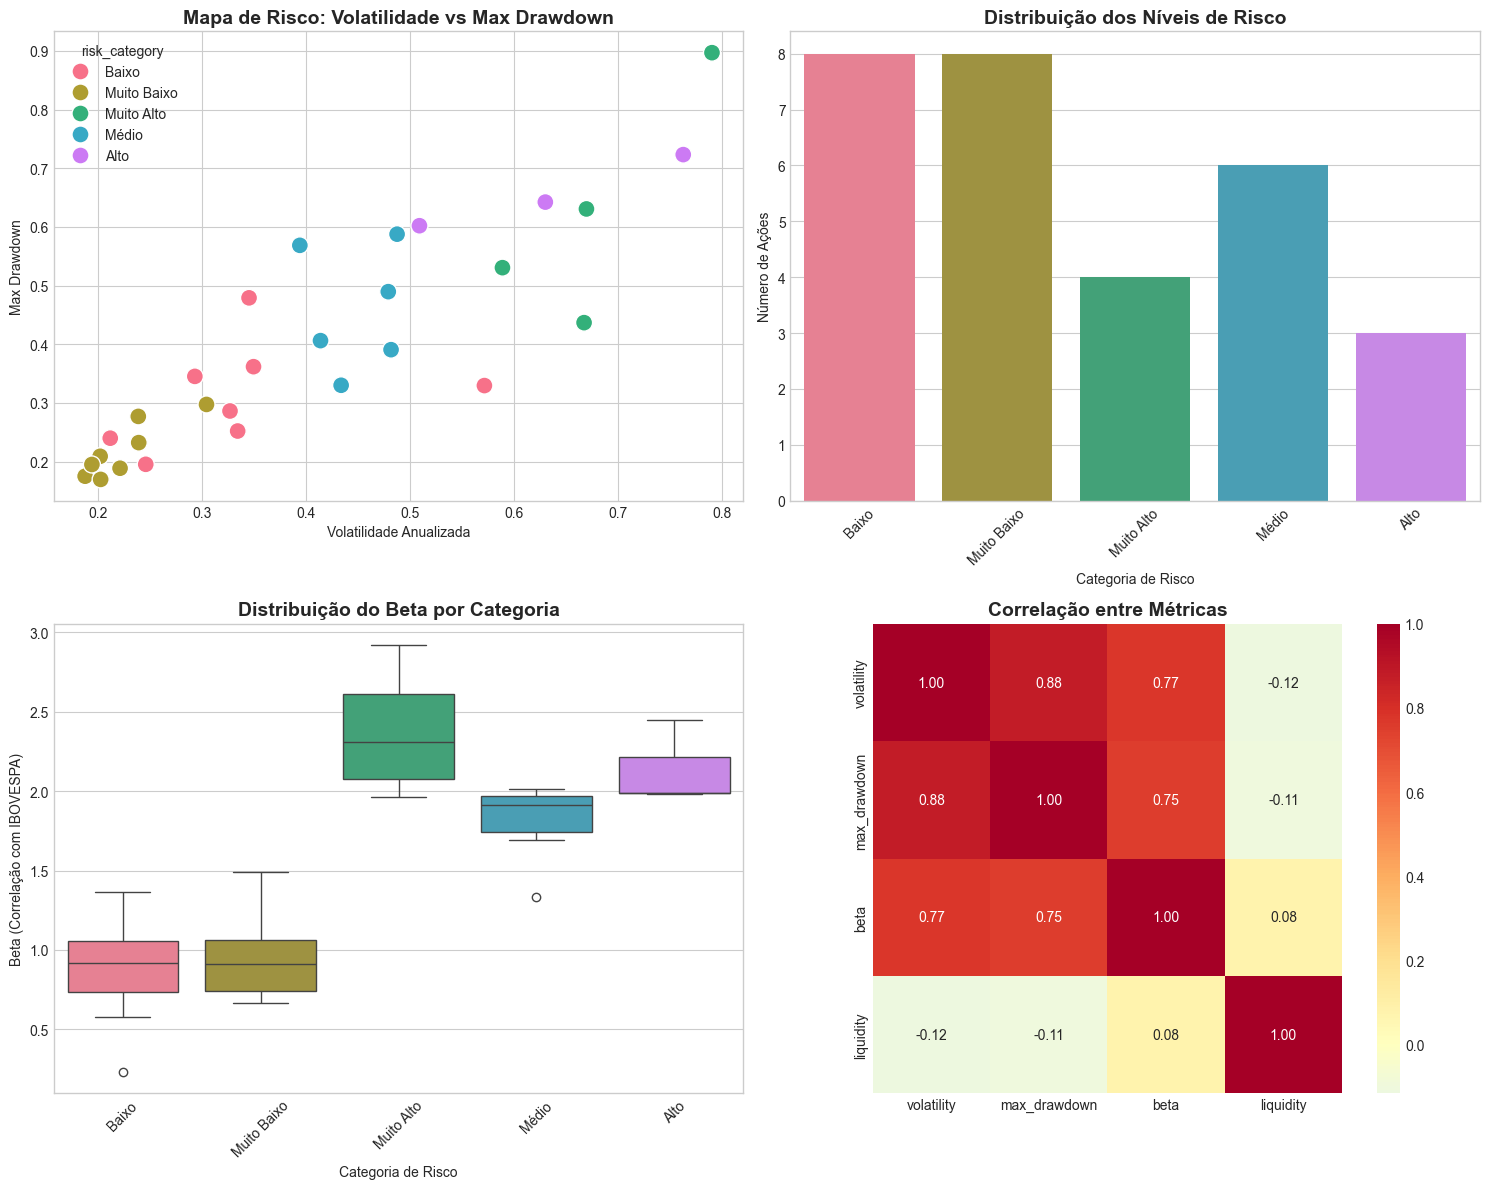

✅ Visualizações geradas com sucesso!
📁 Arquivo salvo em: c:\PI-VI\backend\python\..\data\risk_analysis_complete.png


In [13]:
if clf.df_metrics is not None:  
    print("🎨 GERANDO VISUALIZAÇÕES AVANÇADAS...")  
    
    plt.style.use('seaborn-v0_8-whitegrid')  
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))  
    
    # 1. Scatter plot: Volatilidade vs Max Drawdown  
    ax1 = axes[0, 0]  
    sns.scatterplot(data=clf.df_metrics, x='volatility', y='max_drawdown',  
                    hue='risk_category', palette='husl', s=150, ax=ax1)  
    ax1.set_title('Mapa de Risco: Volatilidade vs Max Drawdown', fontsize=14, fontweight='bold')  
    ax1.set_xlabel('Volatilidade Anualizada')  
    ax1.set_ylabel('Max Drawdown')  
    
    # 2. Histograma de distribuição de risco  
    ax2 = axes[0, 1]  
    sns.countplot(data=clf.df_metrics, x='risk_category', palette='husl', ax=ax2)  
    ax2.set_title('Distribuição dos Níveis de Risco', fontsize=14, fontweight='bold')  
    ax2.set_xlabel('Categoria de Risco')  
    ax2.set_ylabel('Número de Ações')  
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)  
    
    # 3. Boxplot: Beta por categoria  
    ax3 = axes[1, 0]  
    sns.boxplot(data=clf.df_metrics, x='risk_category', y='beta', palette='husl', ax=ax3)  
    ax3.set_title('Distribuição do Beta por Categoria', fontsize=14, fontweight='bold')  
    ax3.set_xlabel('Categoria de Risco')  
    ax3.set_ylabel('Beta (Correlação com IBOVESPA)')  
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)  
    
    # 4. Heatmap de correlação das métricas  
    ax4 = axes[1, 1]  
    correlation_matrix = clf.df_metrics[['volatility', 'max_drawdown', 'beta', 'liquidity']].corr()  
    sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0,  
                square=True, fmt='.2f', ax=ax4)  
    ax4.set_title('Correlação entre Métricas', fontsize=14, fontweight='bold')  
    
    plt.tight_layout()  
    plt.savefig(os.path.join(DATA_DIR, 'risk_analysis_complete.png'), dpi=300, bbox_inches='tight')  
    plt.show()  
    
    print("✅ Visualizações geradas com sucesso!")  
    print(f"📁 Arquivo salvo em: {os.path.join(DATA_DIR, 'risk_analysis_complete.png')}")  
else:  
    print("⚠️ Dados não disponíveis para visualização")  

### 11. Conclusões e Insights
#### 11.1 Resumo dos Resultados

In [14]:
# Análise final dos resultados
if clf.df_metrics is not None:
    print("🎯 ANÁLISE FINAL DOS RESULTADOS")
    print("=" * 50)
    
    # Insights principais
    volatility_mean = clf.df_metrics['volatility'].mean()
    drawdown_mean = clf.df_metrics['max_drawdown'].mean()
    beta_mean = clf.df_metrics['beta'].mean()
    
    print(f"📊 Volatilidade média do portfólio: {volatility_mean:.3f}")
    print(f"📉 Drawdown médio: {drawdown_mean:.3f}")
    print(f"📈 Beta médio (vs IBOVESPA): {beta_mean:.3f}")
    
    # Identificação de ações defensivas e agressivas
    defensive_stocks = clf.df_metrics[
        (clf.df_metrics['volatility'] < volatility_mean) &
        (clf.df_metrics['beta'] < beta_mean)
    ]
    
    aggressive_stocks = clf.df_metrics[
        (clf.df_metrics['volatility'] > volatility_mean) &
        (clf.df_metrics['beta'] > beta_mean)
    ]
    
    print(f"\n🛡️ Ações Defensivas ({len(defensive_stocks)}):")
    for _, stock in defensive_stocks.iterrows():
        print(f"    {stock['ticker']}: {stock['risk_category']}")
    
    print(f"\n⚡ Ações Agressivas ({len(aggressive_stocks)}):")
    for _, stock in aggressive_stocks.iterrows():
        print(f"    {stock['ticker']}: {stock['risk_category']}")
    
    # Recomendações baseadas no perfil de risco
    print("\n🎯 RECOMENDAÇÕES POR PERFIL DE INVESTIDOR:")
    conservative = clf.df_metrics[clf.df_metrics['risk_category'].isin(['Muito Baixo', 'Baixo'])]
    moderate = clf.df_metrics[clf.df_metrics['risk_category'] == 'Médio']
    aggressive_risk = clf.df_metrics[clf.df_metrics['risk_category'].isin(['Alto', 'Muito Alto'])]
    
    print(f"\n🛡️ Perfil Conservador ({len(conservative)} ações):")
    if len(conservative) > 0:
        print(f"    Tickers: {', '.join(conservative['ticker'].tolist())}")
    
    print(f"\n⚖️ Perfil Moderado ({len(moderate)} ações):")
    if len(moderate) > 0:
        print(f"    Tickers: {', '.join(moderate['ticker'].tolist())}")
    
    print(f"\n🚀 Perfil Agressivo ({len(aggressive_risk)} ações):")
    if len(aggressive_risk) > 0:
        print(f"    Tickers: {', '.join(aggressive_risk['ticker'].tolist())}")
else:
    print("⚠️ Análise final não disponível")


🎯 ANÁLISE FINAL DOS RESULTADOS
📊 Volatilidade média do portfólio: 0.406
📉 Drawdown médio: 0.395
📈 Beta médio (vs IBOVESPA): 1.426

🛡️ Ações Defensivas (14):
    JBSS3: Baixo
    BBAS3: Muito Baixo
    PETR4: Muito Baixo
    ABEV3: Muito Baixo
    ITSA4: Muito Baixo
    BBDC4: Muito Baixo
    ITUB4: Muito Baixo
    VALE3: Muito Baixo
    GGBR4: Baixo
    RADL3: Baixo
    GMAT3: Baixo
    SUZB3: Baixo
    PRIO3: Baixo
    PETR3: Baixo

⚡ Ações Agressivas (11):
    COGN3: Muito Alto
    MGLU3: Muito Alto
    AZUL4: Muito Alto
    LREN3: Médio
    VAMO3: Alto
    CVCB3: Muito Alto
    RENT3: Médio
    BHIA3: Alto
    ASAI3: Médio
    MRVE3: Médio
    HAPV3: Alto

🎯 RECOMENDAÇÕES POR PERFIL DE INVESTIDOR:

🛡️ Perfil Conservador (16 ações):
    Tickers: JBSS3, BBAS3, PETR4, ABEV3, GOLL4, B3SA3, ITSA4, BBDC4, ITUB4, VALE3, GGBR4, RADL3, GMAT3, SUZB3, PRIO3, PETR3

⚖️ Perfil Moderado (6 ações):
    Tickers: LREN3, RENT3, CSAN3, ASAI3, BEEF3, MRVE3

🚀 Perfil Agressivo (7 ações):
    Tickers: CO

#### 11.2 Validação e Qualidade dos Dados

In [15]:
# Relatório de qualidade dos dados
print("\n📋 RELATÓRIO DE QUALIDADE DOS DADOS")
print("=" * 45)

if clf.df_metrics is not None:
    # Usar a lista de tickers correta
    total_tickers_attempted = len(sample_tickers)
    successful_analysis = len(clf.df_metrics)
    success_rate = (successful_analysis / total_tickers_attempted) * 100
    
    print(f"✅ Taxa de sucesso: {success_rate:.1f}% ({successful_analysis}/{total_tickers_attempted})")
    
    # Verificação de dados faltantes
    missing_data = clf.df_metrics.isnull().sum()
    print(f"\n📊 Dados faltantes por métrica:")
    for metric, missing_count in missing_data.items():
        if missing_count > 0:
            missing_percentage = (missing_count / len(clf.df_metrics)) * 100
            print(f"    {metric}: {missing_count} ({missing_percentage:.1f}%)")
    
    # Estatísticas de qualidade por métrica
    print(f"\n📈 Estatísticas de qualidade:")
    quality_metrics = ['volatility', 'max_drawdown', 'beta', 'liquidity']
    for metric in quality_metrics:
        if metric in clf.df_metrics.columns:
            values = clf.df_metrics[metric].dropna()
            print(f"    {metric}:")
            print(f"        Válidos: {len(values)}/{len(clf.df_metrics)}")
            print(f"        Min: {values.min():.3f}")
            print(f"        Max: {values.max():.3f}")
            print(f"        Desvio padrão: {values.std():.3f}")
    
    # Salvando relatório final
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    report_filename = os.path.join(DATA_DIR, f"risk_analysis_report_{timestamp}.txt")
    
    try:
        with open(report_filename, 'w', encoding='utf-8') as f:
            f.write("RELATÓRIO DE ANÁLISE DE RISCO - AÇÕES B3\n")
            f.write("=" * 50 + "\n")
            f.write(f"Data/Hora: {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}\n")
            f.write(f"Período analisado: {PERIOD}\n")
            f.write(f"Benchmark: {BENCHMARK}\n")
            f.write(f"Método de clustering: {clf.cluster_method}\n")
            f.write(f"Número de clusters: {clf.n_clusters}\n\n")
            
            f.write(f"Total de ações analisadas: {len(clf.df_metrics)}\n")
            f.write("Distribuição por categoria de risco:\n")
            risk_dist = clf.df_metrics['risk_category'].value_counts()
            for category, count in risk_dist.items():
                percentage = (count / len(clf.df_metrics)) * 100
                f.write(f"    {category}: {count} ações ({percentage:.1f}%)\n")
        
        print(f"\n📁 Relatório final salvo em: {report_filename}")
    except Exception as e:
        print(f"⚠️ Erro ao salvar relatório: {e}")
    
    print("\n🎉 ANÁLISE CONCLUÍDA COM SUCESSO!")
else:
    print("⚠️ Dados não disponíveis para relatório de qualidade")



📋 RELATÓRIO DE QUALIDADE DOS DADOS
✅ Taxa de sucesso: 100.0% (29/29)

📊 Dados faltantes por métrica:
    pe_ratio: 9 (31.0%)
    roe: 2 (6.9%)
    dividend_yield: 8 (27.6%)

📈 Estatísticas de qualidade:
    volatility:
        Válidos: 29/29
        Min: 0.187
        Max: 0.791
        Desvio padrão: 0.182
    max_drawdown:
        Válidos: 29/29
        Min: 0.170
        Max: 0.897
        Desvio padrão: 0.189
    beta:
        Válidos: 29/29
        Min: 0.231
        Max: 2.920
        Desvio padrão: 0.674
    liquidity:
        Válidos: 29/29
        Min: 3.841
        Max: 46.856
        Desvio padrão: 12.207

📁 Relatório final salvo em: c:\PI-VI\backend\python\..\data\risk_analysis_report_20250614_083049.txt

🎉 ANÁLISE CONCLUÍDA COM SUCESSO!


#### 📝 Referências e Documentação   
- Yahoo Finance API: yfinance Documentation   
- Scikit-learn Clustering: Clustering Documentation   
- Modern Portfolio Theory: Markowitz, H. (1952)   
- CAPM Model: Sharpe, W. F. (1964)    
- B3 - Brasil Bolsa Balcão: Site Oficial  